In [19]:
%matplotlib inline
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.utils import save_image
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
import logging

TRAIN_LOSSES_LOGFILE = "train_losses.log"

class LossesLogger(object):
    def __init__(self, file_path_name):
        if os.path.isfile(file_path_name):
            os.remove(file_path_name)
        
        self.logger = logging.getLogger("losses_logger")
        self.logger.setLevel(1)
        file_handler = logging.FileHandler(file_path_name)
        file_handler.setLevel(1)
        self.logger.addHandler(file_handler)
        
        header = ",".join(["Epoch", "Loss", "Value"])
        self.logger.debug(header)
    
    def log(self, epoch, losses_storer):
        for k, v in losses_storer.item():
            log_string = ",".join(str(item) for item in [epoch, k, sum(v)/len(l)])
            self.logger.debug(log_string)

In [3]:
from timeit import default_timer
from collections import defaultdict
from tqdm import trange

class Trainer():
    def __init__(self, model, optimizer, loss_f, device, logger=logging.getLogger(__name__),
                 save_dir="results", is_progress_bar=True):
            self.device = device
            self.model = model.to(device)
            self.loss_f = loss_f
            self.optimizer = optimizer
            self.save_dir = save_dir
            self.is_progress_bar = is_progress_bar
            self.logger = logger
            self.losses_logger = LossesLogger(os.path.join(self.save_dir, TRAIN_LOSSES_LOGFILE))
            self.logger.info("Training Device: {}".format(self.device))
            
    def __call__(self, data_loader, epochs=10, checkpoint_every=10):
        start = default_timer()
        self.model.train()
        for epoch in range(epochs):
            storer = defaultdict(list)
            mean_epoch_loss = self._train_epoch(data_loader, storer, epoch)
            mean_epoch_loss = self._test_epoch(data_loader, storer, epoch)
            with torch.no_grad():
                sample = torch.randn(64, self.model.latent_dim).to(device)
                sample = self.model.decoder(sample).cpu()  # make sure on cpu
                save_image(sample.view(64, 1, 32, 32),
                           './results/samples/' + str(epoch) + '.png')
            
    def _train_epoch(self, data_loader, storer, epoch):
        epoch_loss = 0.
        kwargs = dict(desc="Epoch {}".format(epoch + 1), leave=False,
                      disable=not self.is_progress_bar)
        with trange(len(data_loader), **kwargs) as t:
            for _, (data, _) in enumerate(data_loader):
                iter_loss = self._train_iteration(data, storer)
                epoch_loss += iter_loss
                t.set_postfix(loss=iter_loss)
                t.update()
        mean_epoch_loss = epoch_loss / len(data_loader)
        return mean_epoch_loss
    
    def _train_iteration(self, data, storer):
        batch_size, channel, height, width = data.size()
        data = data.to(self.device)
        recon_batch, latent_dist, latent_sample = self.model(data)
        loss = self.loss_f(data, recon_batch, latent_dist, self.model.training, 
                           storer, latent_sample=latent_sample)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
            
        return loss.item()
    
    def _test_epoch(self, data_loader, storer, epoch):
        epoch_loss = 0.
        kwargs = dict(desc="Epoch {}".format(epoch + 1), leave=False,
                      disable=not self.is_progress_bar)
        with trange(len(data_loader), **kwargs) as t:
            for _, (data, _) in enumerate(data_loader):
                iter_loss = self._train_iteration(data, storer)
                epoch_loss += iter_loss
                t.set_postfix(loss=iter_loss)
                t.update()
        mean_epoch_loss = epoch_loss / len(data_loader)
        return mean_epoch_loss
    
    def _test_iteration(self, data, storer):
        batch_size, channel, height, width = data.size()
        data = data.to(self.device)
        recon_batch, latent_dist, latent_sample = self.model(data)
        loss = self.loss_f(data, recon_batch, latent_dist, self.model.training, 
                               storer, latent_sample=latent_sample)
            
        return loss.item()

In [4]:
LOSSES = ["betaH", "betaB"]
RECON_DIST = ["bernoulli", "laplace", "gaussian"]

In [5]:
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms

batch_size = 64

mnist_dataset = datasets.MNIST('../../data', 
                   train=True, 
                   download=True, 
                   transform=transforms.Compose([
                       transforms.Resize(32),
                       transforms.ToTensor()
                   ]))

mnist_dataset_test = datasets.MNIST('../../data', train=False, download=True, transform=transforms.Compose([
                       transforms.Resize(32),
                       transforms.ToTensor()
                   ]))

train_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(mnist_dataset_test, batch_size=batch_size, shuffle=True)

In [6]:
RES_DIR = "./results"
formatter = logging.Formatter('%(asctime)s %(levelname)s - %(funcName)s: %(message)s',
                                  "%H:%M:%S")
logger = logging.getLogger(__name__)
logger.setLevel(1)
stream = logging.StreamHandler()
stream.setLevel(1)
stream.setFormatter(formatter)
logger.addHandler(stream)

exp_dir = os.path.join(RES_DIR, "first")
# logger.info("Root directory for saving and loading experiments: {}".format(exp_dir))

In [6]:
from vae import VAE
from losses import get_loss_fn
from torch import optim

latent_dim = 12
img_size = [1,32,32]

lr = 5e-4

betaB_args = {"rec_dist": "bernoulli",
              "reg_anneal": 10000, 
              "betaH_B": 4,
              "betaB_initC": 0,
              "betaB_finC": 25,
              "betaB_G": 100
             }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_f = get_loss_fn("betaB", n_data=len(train_loader.dataset), device=device, **betaB_args)

generator_model = VAE(img_size, latent_dim).to(device)
optimizer = optim.Adam(generator_model.parameters(), lr=lr)

In [8]:
trainer = Trainer(generator_model, optimizer, loss_f, device, logger=logger,
                 save_dir=exp_dir, is_progress_bar=False)

15:48:13 INFO - __init__: Training Device: cuda


In [9]:
epochs = 100
checkpoint_every = 10
trainer(train_loader, epochs=epochs, checkpoint_every=checkpoint_every)

In [9]:
class Config:
    def __init__(self, generator, device, image_size=32, mode='train', model_path='./models',
                 generate_path='./Generated', num_epochs=100, distance_weight=1.0, 
                 dataset='MNIST', tensorboard=True, batch_size=64, batch_size_test=1000):
        self.mode = mode
        self.image_size = image_size
        self.model_path = model_path
        self.generate_path = generate_path
        self.dataset = dataset
        self.num_epochs = num_epochs
        self.distance_weight = distance_weight
        self.tensorboard = tensorboard
        self.generator = generator
        self.batch_size = batch_size
        self.batch_size_test = batch_size_test
        self.device = device

config = Config(generator=generator_model, device=device, num_epochs=400, tensorboard=True)

In [10]:
from discriminator import SiameseDiscriminator
from siameseDataset import SiameseMNIST

mnist_siamese_dataset = SiameseMNIST(mnist_dataset)
mnist_siamese_dataset_test = SiameseMNIST(mnist_dataset_test)

siamese_data_loader = DataLoader(dataset=mnist_siamese_dataset, batch_size=config.batch_size, shuffle=True)
siamese_data_loader_test = DataLoader(dataset=mnist_siamese_dataset_test, batch_size=config.batch_size_test, shuffle=True)

In [13]:
from generator import SiameseGanSolver
from mail import send_mail

start_time = datetime.now()

solver = SiameseGanSolver(config, siamese_data_loader)
solver.train()

end_time = datetime.now()
print(send_mail(start_time, end_time))

  0%|          | 0/400 [00:00<?, ?it/s]

We are training

0 2020-01-22 16:16:37.475437


  0%|          | 1/400 [00:32<3:38:58, 32.93s/it]

1 2020-01-22 16:17:10.403979


  0%|          | 2/400 [01:05<3:38:28, 32.94s/it]

2 2020-01-22 16:17:43.363019


  1%|          | 3/400 [01:38<3:37:50, 32.92s/it]

3 2020-01-22 16:18:16.248719


  1%|          | 4/400 [02:11<3:37:19, 32.93s/it]

4 2020-01-22 16:18:49.189288


  1%|▏         | 5/400 [02:44<3:37:07, 32.98s/it]

5 2020-01-22 16:19:22.295299


  2%|▏         | 6/400 [03:17<3:36:34, 32.98s/it]

6 2020-01-22 16:19:55.276090


  2%|▏         | 7/400 [03:50<3:36:08, 33.00s/it]

7 2020-01-22 16:20:28.319841


  2%|▏         | 8/400 [04:23<3:35:39, 33.01s/it]

8 2020-01-22 16:21:01.348143


  2%|▏         | 9/400 [04:56<3:35:18, 33.04s/it]

9 2020-01-22 16:21:34.456835


  2%|▎         | 10/400 [05:30<3:35:08, 33.10s/it]

10 2020-01-22 16:22:07.697922


  3%|▎         | 11/400 [06:03<3:34:26, 33.07s/it]

11 2020-01-22 16:22:40.714403


  3%|▎         | 12/400 [06:36<3:33:34, 33.03s/it]

12 2020-01-22 16:23:13.630787


  3%|▎         | 13/400 [07:09<3:32:56, 33.01s/it]

13 2020-01-22 16:23:46.617953


  4%|▎         | 14/400 [07:42<3:32:28, 33.03s/it]

14 2020-01-22 16:24:19.668080


  4%|▍         | 15/400 [08:15<3:31:36, 32.98s/it]

15 2020-01-22 16:24:52.534969


  4%|▍         | 16/400 [08:48<3:31:14, 33.01s/it]

16 2020-01-22 16:25:25.610905


  4%|▍         | 17/400 [09:21<3:30:44, 33.01s/it]

17 2020-01-22 16:25:58.640358


  4%|▍         | 18/400 [09:54<3:30:10, 33.01s/it]

18 2020-01-22 16:26:31.648123


  5%|▍         | 19/400 [10:27<3:29:54, 33.06s/it]

19 2020-01-22 16:27:04.804142


  5%|▌         | 20/400 [11:00<3:29:02, 33.01s/it]

20 2020-01-22 16:27:37.695605


  5%|▌         | 21/400 [11:33<3:28:19, 32.98s/it]

21 2020-01-22 16:28:10.612105


  6%|▌         | 22/400 [12:06<3:27:50, 32.99s/it]

22 2020-01-22 16:28:43.632236


  6%|▌         | 23/400 [12:39<3:27:23, 33.01s/it]

23 2020-01-22 16:29:16.670098


  6%|▌         | 24/400 [13:12<3:27:14, 33.07s/it]

24 2020-01-22 16:29:49.892458


  6%|▋         | 25/400 [13:45<3:26:44, 33.08s/it]

25 2020-01-22 16:30:22.988003


  6%|▋         | 26/400 [14:18<3:26:03, 33.06s/it]

26 2020-01-22 16:30:56.001389


  7%|▋         | 27/400 [14:51<3:25:40, 33.09s/it]

27 2020-01-22 16:31:29.149249


  7%|▋         | 28/400 [15:24<3:24:58, 33.06s/it]

28 2020-01-22 16:32:02.155359


  7%|▋         | 29/400 [15:57<3:24:22, 33.05s/it]

29 2020-01-22 16:32:35.187771


  8%|▊         | 30/400 [16:30<3:23:50, 33.06s/it]

30 2020-01-22 16:33:08.249188


  8%|▊         | 31/400 [17:03<3:23:15, 33.05s/it]

31 2020-01-22 16:33:41.286720


  8%|▊         | 32/400 [17:36<3:22:32, 33.02s/it]

32 2020-01-22 16:34:14.247425


  8%|▊         | 33/400 [18:09<3:22:03, 33.03s/it]

33 2020-01-22 16:34:47.308305


  8%|▊         | 34/400 [18:42<3:21:28, 33.03s/it]

34 2020-01-22 16:35:20.322226


  9%|▉         | 35/400 [19:15<3:20:46, 33.00s/it]

35 2020-01-22 16:35:53.270980


  9%|▉         | 36/400 [19:48<3:20:08, 32.99s/it]

36 2020-01-22 16:36:26.229478


  9%|▉         | 37/400 [20:21<3:19:46, 33.02s/it]

37 2020-01-22 16:36:59.320919


 10%|▉         | 38/400 [20:54<3:19:12, 33.02s/it]

38 2020-01-22 16:37:32.329004


 10%|▉         | 39/400 [21:28<3:18:55, 33.06s/it]

39 2020-01-22 16:38:05.501330


 10%|█         | 40/400 [22:01<3:18:28, 33.08s/it]

40 2020-01-22 16:38:38.613993


 10%|█         | 41/400 [22:34<3:17:53, 33.07s/it]

41 2020-01-22 16:39:11.681135


 10%|█         | 42/400 [23:07<3:17:31, 33.10s/it]

42 2020-01-22 16:39:44.854531


 11%|█         | 43/400 [23:40<3:16:32, 33.03s/it]

43 2020-01-22 16:40:17.720040


 11%|█         | 44/400 [24:13<3:15:41, 32.98s/it]

44 2020-01-22 16:40:50.580748


 11%|█▏        | 45/400 [24:46<3:15:08, 32.98s/it]

45 2020-01-22 16:41:23.568476


 12%|█▏        | 46/400 [25:19<3:14:43, 33.00s/it]

46 2020-01-22 16:41:56.620136


 12%|█▏        | 47/400 [25:52<3:14:15, 33.02s/it]

47 2020-01-22 16:42:29.671216


 12%|█▏        | 48/400 [26:25<3:13:34, 33.00s/it]

48 2020-01-22 16:43:02.615177


 12%|█▏        | 49/400 [26:58<3:12:56, 32.98s/it]

49 2020-01-22 16:43:35.562885


 12%|█▎        | 50/400 [27:30<3:12:15, 32.96s/it]

50 2020-01-22 16:44:08.466457


 13%|█▎        | 51/400 [28:04<3:11:52, 32.99s/it]

51 2020-01-22 16:44:41.516051


 13%|█▎        | 52/400 [28:37<3:11:16, 32.98s/it]

52 2020-01-22 16:45:14.478468


 13%|█▎        | 53/400 [29:09<3:10:35, 32.95s/it]

53 2020-01-22 16:45:47.376049


 14%|█▎        | 54/400 [29:42<3:10:10, 32.98s/it]

54 2020-01-22 16:46:20.407116


 14%|█▍        | 55/400 [30:15<3:09:38, 32.98s/it]

55 2020-01-22 16:46:53.402169


 14%|█▍        | 56/400 [30:49<3:09:18, 33.02s/it]

56 2020-01-22 16:47:26.508642


 14%|█▍        | 57/400 [31:21<3:08:36, 32.99s/it]

57 2020-01-22 16:47:59.441962


 14%|█▍        | 58/400 [31:54<3:08:06, 33.00s/it]

58 2020-01-22 16:48:32.461845


 15%|█▍        | 59/400 [32:27<3:07:25, 32.98s/it]

59 2020-01-22 16:49:05.382017


 15%|█▌        | 60/400 [33:00<3:06:57, 32.99s/it]

60 2020-01-22 16:49:38.412623


 15%|█▌        | 61/400 [33:33<3:06:25, 33.00s/it]

61 2020-01-22 16:50:11.415319


 16%|█▌        | 62/400 [34:06<3:05:56, 33.01s/it]

62 2020-01-22 16:50:44.445757


 16%|█▌        | 63/400 [34:40<3:05:30, 33.03s/it]

63 2020-01-22 16:51:17.527670


 16%|█▌        | 64/400 [35:13<3:05:04, 33.05s/it]

64 2020-01-22 16:51:50.619450


 16%|█▋        | 65/400 [35:46<3:04:33, 33.06s/it]

65 2020-01-22 16:52:23.691731


 16%|█▋        | 66/400 [36:19<3:04:00, 33.05s/it]

66 2020-01-22 16:52:56.741340


 17%|█▋        | 67/400 [36:52<3:03:29, 33.06s/it]

67 2020-01-22 16:53:29.824158


 17%|█▋        | 68/400 [37:25<3:02:45, 33.03s/it]

68 2020-01-22 16:54:02.769562


 17%|█▋        | 69/400 [37:58<3:02:07, 33.01s/it]

69 2020-01-22 16:54:35.750521


 18%|█▊        | 70/400 [38:31<3:01:39, 33.03s/it]

70 2020-01-22 16:55:08.814658


 18%|█▊        | 71/400 [39:04<3:01:17, 33.06s/it]

71 2020-01-22 16:55:41.953174


 18%|█▊        | 72/400 [39:37<3:00:30, 33.02s/it]

72 2020-01-22 16:56:14.879292


 18%|█▊        | 73/400 [40:10<3:00:11, 33.06s/it]

73 2020-01-22 16:56:48.034297


 18%|█▊        | 74/400 [40:43<2:59:32, 33.05s/it]

74 2020-01-22 16:57:21.042420


 19%|█▉        | 75/400 [41:16<2:58:57, 33.04s/it]

75 2020-01-22 16:57:54.062501


 19%|█▉        | 76/400 [41:49<2:58:22, 33.03s/it]

76 2020-01-22 16:58:27.084741


 19%|█▉        | 77/400 [42:22<2:57:41, 33.01s/it]

77 2020-01-22 16:59:00.036141


 20%|█▉        | 78/400 [42:55<2:57:22, 33.05s/it]

78 2020-01-22 16:59:33.186094


 20%|█▉        | 79/400 [43:28<2:56:45, 33.04s/it]

79 2020-01-22 17:00:06.199534


 20%|██        | 80/400 [44:01<2:56:03, 33.01s/it]

80 2020-01-22 17:00:39.140386


 20%|██        | 81/400 [44:34<2:55:18, 32.97s/it]

81 2020-01-22 17:01:12.027815


 20%|██        | 82/400 [45:07<2:54:55, 33.00s/it]

82 2020-01-22 17:01:45.105924


 21%|██        | 83/400 [45:40<2:54:29, 33.03s/it]

83 2020-01-22 17:02:18.188173


 21%|██        | 84/400 [46:13<2:53:53, 33.02s/it]

84 2020-01-22 17:02:51.183681


 21%|██▏       | 85/400 [46:46<2:53:28, 33.04s/it]

85 2020-01-22 17:03:24.281323


 22%|██▏       | 86/400 [47:19<2:53:01, 33.06s/it]

86 2020-01-22 17:03:57.394646


 22%|██▏       | 87/400 [47:52<2:52:27, 33.06s/it]

87 2020-01-22 17:04:30.445050


 22%|██▏       | 88/400 [48:25<2:51:48, 33.04s/it]

88 2020-01-22 17:05:03.439523


 22%|██▏       | 89/400 [48:59<2:51:15, 33.04s/it]

89 2020-01-22 17:05:36.485236


 22%|██▎       | 90/400 [49:32<2:50:43, 33.04s/it]

90 2020-01-22 17:06:09.531478


 23%|██▎       | 91/400 [50:05<2:50:17, 33.07s/it]

91 2020-01-22 17:06:42.652369


 23%|██▎       | 92/400 [50:38<2:49:49, 33.08s/it]

92 2020-01-22 17:07:15.779010


 23%|██▎       | 93/400 [51:11<2:49:20, 33.10s/it]

93 2020-01-22 17:07:48.898877


 24%|██▎       | 94/400 [51:44<2:48:39, 33.07s/it]

94 2020-01-22 17:08:21.910999


 24%|██▍       | 95/400 [52:17<2:47:59, 33.05s/it]

95 2020-01-22 17:08:54.907099


 24%|██▍       | 96/400 [52:50<2:47:31, 33.06s/it]

96 2020-01-22 17:09:28.003881


 24%|██▍       | 97/400 [53:23<2:46:58, 33.06s/it]

97 2020-01-22 17:10:01.069115


 24%|██▍       | 98/400 [53:56<2:46:11, 33.02s/it]

98 2020-01-22 17:10:33.987154


 25%|██▍       | 99/400 [54:29<2:45:38, 33.02s/it]

99 2020-01-22 17:11:07.008421


 25%|██▌       | 100/400 [55:02<2:45:11, 33.04s/it]

100 2020-01-22 17:11:40.091853


 25%|██▌       | 101/400 [55:35<2:44:40, 33.04s/it]

101 2020-01-22 17:12:13.149029


 26%|██▌       | 102/400 [56:08<2:44:05, 33.04s/it]

102 2020-01-22 17:12:46.168740


 26%|██▌       | 103/400 [56:41<2:43:17, 32.99s/it]

103 2020-01-22 17:13:19.046894


 26%|██▌       | 104/400 [57:14<2:42:48, 33.00s/it]

104 2020-01-22 17:13:52.070820


 26%|██▋       | 105/400 [57:47<2:42:08, 32.98s/it]

105 2020-01-22 17:14:25.002661


 26%|██▋       | 106/400 [58:20<2:41:43, 33.01s/it]

106 2020-01-22 17:14:58.071086


 27%|██▋       | 107/400 [58:53<2:41:14, 33.02s/it]

107 2020-01-22 17:15:31.118755


 27%|██▋       | 108/400 [59:26<2:40:34, 33.00s/it]

108 2020-01-22 17:16:04.062456


 27%|██▋       | 109/400 [59:59<2:40:17, 33.05s/it]

109 2020-01-22 17:16:37.234242


 28%|██▊       | 110/400 [1:00:32<2:39:37, 33.03s/it]

110 2020-01-22 17:17:10.206786


 28%|██▊       | 111/400 [1:01:05<2:39:10, 33.05s/it]

111 2020-01-22 17:17:43.297505


 28%|██▊       | 112/400 [1:01:38<2:38:17, 32.98s/it]

112 2020-01-22 17:18:16.113309


 28%|██▊       | 113/400 [1:02:11<2:37:39, 32.96s/it]

113 2020-01-22 17:18:49.030967


 28%|██▊       | 114/400 [1:02:44<2:37:00, 32.94s/it]

114 2020-01-22 17:19:21.924656


 29%|██▉       | 115/400 [1:03:17<2:36:40, 32.99s/it]

115 2020-01-22 17:19:55.018006


 29%|██▉       | 116/400 [1:03:50<2:36:12, 33.00s/it]

116 2020-01-22 17:20:28.057070


 29%|██▉       | 117/400 [1:04:23<2:35:33, 32.98s/it]

117 2020-01-22 17:21:00.986722


 30%|██▉       | 118/400 [1:04:56<2:35:29, 33.08s/it]

118 2020-01-22 17:21:34.315136


 30%|██▉       | 119/400 [1:05:29<2:34:43, 33.04s/it]

119 2020-01-22 17:22:07.247321


 30%|███       | 120/400 [1:06:02<2:34:05, 33.02s/it]

120 2020-01-22 17:22:40.222927


 30%|███       | 121/400 [1:06:35<2:33:29, 33.01s/it]

121 2020-01-22 17:23:13.205604


 30%|███       | 122/400 [1:07:08<2:33:00, 33.02s/it]

122 2020-01-22 17:23:46.263477


 31%|███       | 123/400 [1:07:41<2:32:32, 33.04s/it]

123 2020-01-22 17:24:19.347061


 31%|███       | 124/400 [1:08:14<2:32:03, 33.06s/it]

124 2020-01-22 17:24:52.436865


 31%|███▏      | 125/400 [1:08:47<2:31:24, 33.04s/it]

125 2020-01-22 17:25:25.426376


 32%|███▏      | 126/400 [1:09:20<2:30:53, 33.04s/it]

126 2020-01-22 17:25:58.476098


 32%|███▏      | 127/400 [1:09:53<2:30:08, 33.00s/it]

127 2020-01-22 17:26:31.377158


 32%|███▏      | 128/400 [1:10:26<2:29:29, 32.98s/it]

128 2020-01-22 17:27:04.305441


 32%|███▏      | 129/400 [1:10:59<2:28:52, 32.96s/it]

129 2020-01-22 17:27:37.230492


 32%|███▎      | 130/400 [1:11:32<2:28:26, 32.99s/it]

130 2020-01-22 17:28:10.281047


 33%|███▎      | 131/400 [1:12:05<2:27:53, 32.99s/it]

131 2020-01-22 17:28:43.262591


 33%|███▎      | 132/400 [1:12:38<2:27:14, 32.96s/it]

132 2020-01-22 17:29:16.176079


 33%|███▎      | 133/400 [1:13:11<2:26:40, 32.96s/it]

133 2020-01-22 17:29:49.132658


 34%|███▎      | 134/400 [1:13:44<2:26:21, 33.01s/it]

134 2020-01-22 17:30:22.262643


 34%|███▍      | 135/400 [1:14:17<2:25:43, 33.00s/it]

135 2020-01-22 17:30:55.217315


 34%|███▍      | 136/400 [1:14:50<2:25:18, 33.02s/it]

136 2020-01-22 17:31:28.312043


 34%|███▍      | 137/400 [1:15:23<2:24:48, 33.03s/it]

137 2020-01-22 17:32:01.369742


 34%|███▍      | 138/400 [1:15:56<2:23:59, 32.97s/it]

138 2020-01-22 17:32:34.204580


 35%|███▍      | 139/400 [1:16:29<2:23:27, 32.98s/it]

139 2020-01-22 17:33:07.192404


 35%|███▌      | 140/400 [1:17:02<2:23:08, 33.03s/it]

140 2020-01-22 17:33:40.350165


 35%|███▌      | 141/400 [1:17:35<2:22:31, 33.02s/it]

141 2020-01-22 17:34:13.335265


 36%|███▌      | 142/400 [1:18:08<2:21:56, 33.01s/it]

142 2020-01-22 17:34:46.324218


 36%|███▌      | 143/400 [1:18:41<2:21:27, 33.03s/it]

143 2020-01-22 17:35:19.386713


 36%|███▌      | 144/400 [1:19:15<2:21:03, 33.06s/it]

144 2020-01-22 17:35:52.525269


 36%|███▋      | 145/400 [1:19:48<2:20:32, 33.07s/it]

145 2020-01-22 17:36:25.618506


 36%|███▋      | 146/400 [1:20:21<2:20:04, 33.09s/it]

146 2020-01-22 17:36:58.750656


 37%|███▋      | 147/400 [1:20:54<2:19:24, 33.06s/it]

147 2020-01-22 17:37:31.751023


 37%|███▋      | 148/400 [1:21:27<2:18:45, 33.04s/it]

148 2020-01-22 17:38:04.733958


 37%|███▋      | 149/400 [1:22:00<2:18:11, 33.03s/it]

149 2020-01-22 17:38:37.752785


 38%|███▊      | 150/400 [1:22:33<2:17:31, 33.00s/it]

150 2020-01-22 17:39:10.690863


 38%|███▊      | 151/400 [1:23:06<2:17:00, 33.01s/it]

151 2020-01-22 17:39:43.729008


 38%|███▊      | 152/400 [1:23:39<2:16:30, 33.03s/it]

152 2020-01-22 17:40:16.780441


 38%|███▊      | 153/400 [1:24:12<2:15:56, 33.02s/it]

153 2020-01-22 17:40:49.791386


 38%|███▊      | 154/400 [1:24:45<2:15:21, 33.01s/it]

154 2020-01-22 17:41:22.787135


 39%|███▉      | 155/400 [1:25:18<2:14:52, 33.03s/it]

155 2020-01-22 17:41:55.859901


 39%|███▉      | 156/400 [1:25:51<2:14:19, 33.03s/it]

156 2020-01-22 17:42:28.890656


 39%|███▉      | 157/400 [1:26:24<2:13:53, 33.06s/it]

157 2020-01-22 17:43:02.012783


 40%|███▉      | 158/400 [1:26:57<2:13:25, 33.08s/it]

158 2020-01-22 17:43:35.147526


 40%|███▉      | 159/400 [1:27:30<2:12:49, 33.07s/it]

159 2020-01-22 17:44:08.185270


 40%|████      | 160/400 [1:28:03<2:12:29, 33.12s/it]

160 2020-01-22 17:44:41.431828


 40%|████      | 161/400 [1:28:37<2:11:56, 33.12s/it]

161 2020-01-22 17:45:14.553060


 40%|████      | 162/400 [1:29:10<2:11:14, 33.09s/it]

162 2020-01-22 17:45:47.559948


 41%|████      | 163/400 [1:29:43<2:10:36, 33.06s/it]

163 2020-01-22 17:46:20.570628


 41%|████      | 164/400 [1:30:16<2:10:08, 33.09s/it]

164 2020-01-22 17:46:53.713392


 41%|████▏     | 165/400 [1:30:49<2:09:28, 33.06s/it]

165 2020-01-22 17:47:26.701114


 42%|████▏     | 166/400 [1:31:22<2:09:01, 33.08s/it]

166 2020-01-22 17:47:59.842664


 42%|████▏     | 167/400 [1:31:55<2:08:25, 33.07s/it]

167 2020-01-22 17:48:32.887780


 42%|████▏     | 168/400 [1:32:28<2:07:54, 33.08s/it]

168 2020-01-22 17:49:05.991599


 42%|████▏     | 169/400 [1:33:01<2:07:13, 33.04s/it]

169 2020-01-22 17:49:38.950160


 42%|████▎     | 170/400 [1:33:34<2:06:36, 33.03s/it]

170 2020-01-22 17:50:11.938911


 43%|████▎     | 171/400 [1:34:07<2:06:13, 33.07s/it]

171 2020-01-22 17:50:45.113392


 43%|████▎     | 172/400 [1:34:40<2:05:40, 33.07s/it]

172 2020-01-22 17:51:18.192026


 43%|████▎     | 173/400 [1:35:13<2:05:03, 33.06s/it]

173 2020-01-22 17:51:51.210203


 44%|████▎     | 174/400 [1:35:46<2:04:38, 33.09s/it]

174 2020-01-22 17:52:24.374449


 44%|████▍     | 175/400 [1:36:19<2:04:02, 33.08s/it]

175 2020-01-22 17:52:57.428694


 44%|████▍     | 176/400 [1:36:52<2:03:24, 33.06s/it]

176 2020-01-22 17:53:30.429079


 44%|████▍     | 177/400 [1:37:26<2:02:53, 33.07s/it]

177 2020-01-22 17:54:03.523332


 44%|████▍     | 178/400 [1:37:59<2:02:17, 33.05s/it]

178 2020-01-22 17:54:36.537636


 45%|████▍     | 179/400 [1:38:32<2:01:38, 33.03s/it]

179 2020-01-22 17:55:09.501860


 45%|████▌     | 180/400 [1:39:05<2:01:12, 33.06s/it]

180 2020-01-22 17:55:42.626008


 45%|████▌     | 181/400 [1:39:38<2:00:36, 33.05s/it]

181 2020-01-22 17:56:15.649252


 46%|████▌     | 182/400 [1:40:11<2:00:12, 33.08s/it]

182 2020-01-22 17:56:48.826938


 46%|████▌     | 183/400 [1:40:44<1:59:39, 33.09s/it]

183 2020-01-22 17:57:21.913268


 46%|████▌     | 184/400 [1:41:17<1:58:53, 33.02s/it]

184 2020-01-22 17:57:54.797175


 46%|████▋     | 185/400 [1:41:50<1:58:08, 32.97s/it]

185 2020-01-22 17:58:27.640030


 46%|████▋     | 186/400 [1:42:23<1:57:35, 32.97s/it]

186 2020-01-22 17:59:00.614628


 47%|████▋     | 187/400 [1:42:56<1:57:02, 32.97s/it]

187 2020-01-22 17:59:33.578957


 47%|████▋     | 188/400 [1:43:28<1:56:22, 32.94s/it]

188 2020-01-22 18:00:06.442863


 47%|████▋     | 189/400 [1:44:02<1:55:59, 32.98s/it]

189 2020-01-22 18:00:39.529323


 48%|████▊     | 190/400 [1:44:35<1:55:37, 33.03s/it]

190 2020-01-22 18:01:12.680558


 48%|████▊     | 191/400 [1:45:08<1:55:07, 33.05s/it]

191 2020-01-22 18:01:45.765135


 48%|████▊     | 192/400 [1:45:41<1:54:34, 33.05s/it]

192 2020-01-22 18:02:18.820355


 48%|████▊     | 193/400 [1:46:14<1:54:02, 33.06s/it]

193 2020-01-22 18:02:51.886776


 48%|████▊     | 194/400 [1:46:47<1:53:27, 33.05s/it]

194 2020-01-22 18:03:24.918809


 49%|████▉     | 195/400 [1:47:20<1:53:02, 33.08s/it]

195 2020-01-22 18:03:58.087286


 49%|████▉     | 196/400 [1:47:53<1:52:32, 33.10s/it]

196 2020-01-22 18:04:31.218891


 49%|████▉     | 197/400 [1:48:26<1:51:53, 33.07s/it]

197 2020-01-22 18:05:04.218618


 50%|████▉     | 198/400 [1:48:59<1:51:18, 33.06s/it]

198 2020-01-22 18:05:37.267059


 50%|████▉     | 199/400 [1:49:32<1:50:45, 33.06s/it]

199 2020-01-22 18:06:10.330624


 50%|█████     | 200/400 [1:50:05<1:50:07, 33.04s/it]

200 2020-01-22 18:06:43.306947


 50%|█████     | 201/400 [1:50:38<1:49:34, 33.04s/it]

201 2020-01-22 18:07:16.347076


 50%|█████     | 202/400 [1:51:12<1:49:08, 33.07s/it]

202 2020-01-22 18:07:49.501686


 51%|█████     | 203/400 [1:51:45<1:48:37, 33.09s/it]

203 2020-01-22 18:08:22.617033


 51%|█████     | 204/400 [1:52:18<1:48:02, 33.07s/it]

204 2020-01-22 18:08:55.663033


 51%|█████▏    | 205/400 [1:52:51<1:47:29, 33.08s/it]

205 2020-01-22 18:09:28.740412


 52%|█████▏    | 206/400 [1:53:24<1:46:54, 33.07s/it]

206 2020-01-22 18:10:01.787191


 52%|█████▏    | 207/400 [1:53:57<1:46:19, 33.06s/it]

207 2020-01-22 18:10:34.819200


 52%|█████▏    | 208/400 [1:54:30<1:45:48, 33.07s/it]

208 2020-01-22 18:11:07.906474


 52%|█████▏    | 209/400 [1:55:03<1:45:14, 33.06s/it]

209 2020-01-22 18:11:40.948143


 52%|█████▎    | 210/400 [1:55:36<1:44:43, 33.07s/it]

210 2020-01-22 18:12:14.042342


 53%|█████▎    | 211/400 [1:56:09<1:44:07, 33.05s/it]

211 2020-01-22 18:12:47.059657


 53%|█████▎    | 212/400 [1:56:42<1:43:34, 33.05s/it]

212 2020-01-22 18:13:20.116386


 53%|█████▎    | 213/400 [1:57:15<1:43:05, 33.08s/it]

213 2020-01-22 18:13:53.253536


 54%|█████▎    | 214/400 [1:57:48<1:42:27, 33.05s/it]

214 2020-01-22 18:14:26.243310


 54%|█████▍    | 215/400 [1:58:21<1:41:44, 33.00s/it]

215 2020-01-22 18:14:59.117832


 54%|█████▍    | 216/400 [1:58:54<1:41:13, 33.01s/it]

216 2020-01-22 18:15:32.139864


 54%|█████▍    | 217/400 [1:59:27<1:40:37, 32.99s/it]

217 2020-01-22 18:16:05.094281


 55%|█████▍    | 218/400 [2:00:00<1:40:05, 33.00s/it]

218 2020-01-22 18:16:38.103254


 55%|█████▍    | 219/400 [2:00:33<1:39:32, 33.00s/it]

219 2020-01-22 18:17:11.108867


 55%|█████▌    | 220/400 [2:01:06<1:39:11, 33.07s/it]

220 2020-01-22 18:17:44.328397


 55%|█████▌    | 221/400 [2:01:39<1:38:39, 33.07s/it]

221 2020-01-22 18:18:17.411265


 56%|█████▌    | 222/400 [2:02:12<1:38:03, 33.05s/it]

222 2020-01-22 18:18:50.428485


 56%|█████▌    | 223/400 [2:02:45<1:37:26, 33.03s/it]

223 2020-01-22 18:19:23.397390


 56%|█████▌    | 224/400 [2:03:18<1:36:55, 33.04s/it]

224 2020-01-22 18:19:56.465511


 56%|█████▋    | 225/400 [2:03:51<1:36:16, 33.01s/it]

225 2020-01-22 18:20:29.407072


 56%|█████▋    | 226/400 [2:04:24<1:35:46, 33.03s/it]

226 2020-01-22 18:21:02.469861


 57%|█████▋    | 227/400 [2:04:57<1:35:12, 33.02s/it]

227 2020-01-22 18:21:35.475454


 57%|█████▋    | 228/400 [2:05:30<1:34:34, 32.99s/it]

228 2020-01-22 18:22:08.393792


 57%|█████▋    | 229/400 [2:06:03<1:34:02, 33.00s/it]

229 2020-01-22 18:22:41.417980


 57%|█████▊    | 230/400 [2:06:36<1:33:22, 32.96s/it]

230 2020-01-22 18:23:14.270839


 58%|█████▊    | 231/400 [2:07:09<1:32:51, 32.97s/it]

231 2020-01-22 18:23:47.259127


 58%|█████▊    | 232/400 [2:07:42<1:32:18, 32.96s/it]

232 2020-01-22 18:24:20.221614


 58%|█████▊    | 233/400 [2:08:15<1:31:50, 33.00s/it]

233 2020-01-22 18:24:53.288673


 58%|█████▊    | 234/400 [2:08:48<1:31:17, 32.99s/it]

234 2020-01-22 18:25:26.283015


 59%|█████▉    | 235/400 [2:09:21<1:30:44, 33.00s/it]

235 2020-01-22 18:25:59.287627


 59%|█████▉    | 236/400 [2:09:54<1:30:18, 33.04s/it]

236 2020-01-22 18:26:32.420230


 59%|█████▉    | 237/400 [2:10:28<1:29:47, 33.05s/it]

237 2020-01-22 18:27:05.495756


 60%|█████▉    | 238/400 [2:11:01<1:29:19, 33.09s/it]

238 2020-01-22 18:27:38.666091


 60%|█████▉    | 239/400 [2:11:34<1:28:47, 33.09s/it]

239 2020-01-22 18:28:11.769939


 60%|██████    | 240/400 [2:12:07<1:28:16, 33.10s/it]

240 2020-01-22 18:28:44.889810


 60%|██████    | 241/400 [2:12:40<1:27:37, 33.07s/it]

241 2020-01-22 18:29:17.884778


 60%|██████    | 242/400 [2:13:13<1:27:08, 33.09s/it]

242 2020-01-22 18:29:51.022684


 61%|██████    | 243/400 [2:13:46<1:26:28, 33.05s/it]

243 2020-01-22 18:30:23.976151


 61%|██████    | 244/400 [2:14:19<1:25:48, 33.01s/it]

244 2020-01-22 18:30:56.884313


 61%|██████▏   | 245/400 [2:14:52<1:25:20, 33.04s/it]

245 2020-01-22 18:31:29.990166


 62%|██████▏   | 246/400 [2:15:25<1:24:44, 33.01s/it]

246 2020-01-22 18:32:02.951461


 62%|██████▏   | 247/400 [2:15:58<1:24:11, 33.02s/it]

247 2020-01-22 18:32:35.973583


 62%|██████▏   | 248/400 [2:16:31<1:23:43, 33.05s/it]

248 2020-01-22 18:33:09.104356


 62%|██████▏   | 249/400 [2:17:04<1:23:07, 33.03s/it]

249 2020-01-22 18:33:42.085158


 62%|██████▎   | 250/400 [2:17:37<1:22:35, 33.03s/it]

250 2020-01-22 18:34:15.126671


 63%|██████▎   | 251/400 [2:18:10<1:22:03, 33.04s/it]

251 2020-01-22 18:34:48.194327


 63%|██████▎   | 252/400 [2:18:43<1:21:27, 33.02s/it]

252 2020-01-22 18:35:21.173934


 63%|██████▎   | 253/400 [2:19:16<1:20:58, 33.05s/it]

253 2020-01-22 18:35:54.296011


 64%|██████▎   | 254/400 [2:19:49<1:20:30, 33.08s/it]

254 2020-01-22 18:36:27.449269


 64%|██████▍   | 255/400 [2:20:22<1:19:54, 33.06s/it]

255 2020-01-22 18:37:00.467099


 64%|██████▍   | 256/400 [2:20:55<1:19:18, 33.04s/it]

256 2020-01-22 18:37:33.464474


 64%|██████▍   | 257/400 [2:21:29<1:18:51, 33.09s/it]

257 2020-01-22 18:38:06.661020


 64%|██████▍   | 258/400 [2:22:02<1:18:14, 33.06s/it]

258 2020-01-22 18:38:39.652128


 65%|██████▍   | 259/400 [2:22:35<1:17:39, 33.04s/it]

259 2020-01-22 18:39:12.655588


 65%|██████▌   | 260/400 [2:23:08<1:17:09, 33.06s/it]

260 2020-01-22 18:39:45.768975


 65%|██████▌   | 261/400 [2:23:41<1:16:32, 33.04s/it]

261 2020-01-22 18:40:18.759828


 66%|██████▌   | 262/400 [2:24:14<1:16:05, 33.08s/it]

262 2020-01-22 18:40:51.935201


 66%|██████▌   | 263/400 [2:24:47<1:15:34, 33.10s/it]

263 2020-01-22 18:41:25.070248


 66%|██████▌   | 264/400 [2:25:20<1:14:59, 33.08s/it]

264 2020-01-22 18:41:58.116638


 66%|██████▋   | 265/400 [2:25:53<1:14:20, 33.04s/it]

265 2020-01-22 18:42:31.047900


 66%|██████▋   | 266/400 [2:26:26<1:13:45, 33.02s/it]

266 2020-01-22 18:43:04.040104


 67%|██████▋   | 267/400 [2:26:59<1:13:08, 32.99s/it]

267 2020-01-22 18:43:36.968513


 67%|██████▋   | 268/400 [2:27:32<1:12:32, 32.97s/it]

268 2020-01-22 18:44:09.894479


 67%|██████▋   | 269/400 [2:28:05<1:12:07, 33.04s/it]

269 2020-01-22 18:44:43.072232


 68%|██████▊   | 270/400 [2:28:38<1:11:33, 33.02s/it]

270 2020-01-22 18:45:16.067169


 68%|██████▊   | 271/400 [2:29:11<1:10:59, 33.02s/it]

271 2020-01-22 18:45:49.074420


 68%|██████▊   | 272/400 [2:29:44<1:10:31, 33.06s/it]

272 2020-01-22 18:46:22.217731


 68%|██████▊   | 273/400 [2:30:17<1:10:00, 33.08s/it]

273 2020-01-22 18:46:55.343103


 68%|██████▊   | 274/400 [2:30:50<1:09:29, 33.09s/it]

274 2020-01-22 18:47:28.458717


 69%|██████▉   | 275/400 [2:31:24<1:08:56, 33.09s/it]

275 2020-01-22 18:48:01.561061


 69%|██████▉   | 276/400 [2:31:57<1:08:21, 33.08s/it]

276 2020-01-22 18:48:34.612238


 69%|██████▉   | 277/400 [2:32:30<1:07:52, 33.11s/it]

277 2020-01-22 18:49:07.782225


 70%|██████▉   | 278/400 [2:33:03<1:07:16, 33.09s/it]

278 2020-01-22 18:49:40.816253


 70%|██████▉   | 279/400 [2:33:36<1:06:48, 33.12s/it]

279 2020-01-22 18:50:14.033386


 70%|███████   | 280/400 [2:34:09<1:06:13, 33.11s/it]

280 2020-01-22 18:50:47.120554


 70%|███████   | 281/400 [2:34:42<1:05:36, 33.08s/it]

281 2020-01-22 18:51:20.129440


 70%|███████   | 282/400 [2:35:15<1:05:03, 33.08s/it]

282 2020-01-22 18:51:53.219759


 71%|███████   | 283/400 [2:35:48<1:04:29, 33.07s/it]

283 2020-01-22 18:52:26.251526


 71%|███████   | 284/400 [2:36:21<1:03:54, 33.06s/it]

284 2020-01-22 18:52:59.290072


 71%|███████▏  | 285/400 [2:36:54<1:03:19, 33.04s/it]

285 2020-01-22 18:53:32.293846


 72%|███████▏  | 286/400 [2:37:27<1:02:47, 33.05s/it]

286 2020-01-22 18:54:05.347766


 72%|███████▏  | 287/400 [2:38:00<1:02:09, 33.01s/it]

287 2020-01-22 18:54:38.268221


 72%|███████▏  | 288/400 [2:38:33<1:01:35, 32.99s/it]

288 2020-01-22 18:55:11.232764


 72%|███████▏  | 289/400 [2:39:06<1:01:05, 33.02s/it]

289 2020-01-22 18:55:44.308005


 72%|███████▎  | 290/400 [2:39:39<1:00:33, 33.03s/it]

290 2020-01-22 18:56:17.352718


 73%|███████▎  | 291/400 [2:40:13<1:00:04, 33.07s/it]

291 2020-01-22 18:56:50.530704


 73%|███████▎  | 292/400 [2:40:46<59:31, 33.07s/it]  

292 2020-01-22 18:57:23.582781


 73%|███████▎  | 293/400 [2:41:19<58:54, 33.03s/it]

293 2020-01-22 18:57:56.523168


 74%|███████▎  | 294/400 [2:41:52<58:22, 33.04s/it]

294 2020-01-22 18:58:29.585637


 74%|███████▍  | 295/400 [2:42:25<57:47, 33.03s/it]

295 2020-01-22 18:59:02.587135


 74%|███████▍  | 296/400 [2:42:58<57:16, 33.04s/it]

296 2020-01-22 18:59:35.661532


 74%|███████▍  | 297/400 [2:43:31<56:42, 33.03s/it]

297 2020-01-22 19:00:08.680134


 74%|███████▍  | 298/400 [2:44:04<56:08, 33.02s/it]

298 2020-01-22 19:00:41.676289


 75%|███████▍  | 299/400 [2:44:37<55:36, 33.03s/it]

299 2020-01-22 19:01:14.730166


 75%|███████▌  | 300/400 [2:45:10<55:05, 33.06s/it]

300 2020-01-22 19:01:47.851833


 75%|███████▌  | 301/400 [2:45:43<54:31, 33.04s/it]

301 2020-01-22 19:02:20.854494


 76%|███████▌  | 302/400 [2:46:16<53:58, 33.05s/it]

302 2020-01-22 19:02:53.921795


 76%|███████▌  | 303/400 [2:46:49<53:26, 33.05s/it]

303 2020-01-22 19:03:26.984262


 76%|███████▌  | 304/400 [2:47:22<52:52, 33.05s/it]

304 2020-01-22 19:04:00.021678


 76%|███████▋  | 305/400 [2:47:55<52:15, 33.00s/it]

305 2020-01-22 19:04:32.909451


 76%|███████▋  | 306/400 [2:48:28<51:45, 33.04s/it]

306 2020-01-22 19:05:06.034202


 77%|███████▋  | 307/400 [2:49:01<51:13, 33.04s/it]

307 2020-01-22 19:05:39.091688


 77%|███████▋  | 308/400 [2:49:34<50:35, 32.99s/it]

308 2020-01-22 19:06:11.958929


 77%|███████▋  | 309/400 [2:50:07<50:03, 33.00s/it]

309 2020-01-22 19:06:44.995922


 78%|███████▊  | 310/400 [2:50:40<49:31, 33.01s/it]

310 2020-01-22 19:07:18.025600


 78%|███████▊  | 311/400 [2:51:13<49:01, 33.06s/it]

311 2020-01-22 19:07:51.182328


 78%|███████▊  | 312/400 [2:51:46<48:28, 33.05s/it]

312 2020-01-22 19:08:24.212089


 78%|███████▊  | 313/400 [2:52:19<47:49, 32.98s/it]

313 2020-01-22 19:08:57.032181


 78%|███████▊  | 314/400 [2:52:52<47:18, 33.00s/it]

314 2020-01-22 19:09:30.089323


 79%|███████▉  | 315/400 [2:53:25<46:45, 33.01s/it]

315 2020-01-22 19:10:03.108932


 79%|███████▉  | 316/400 [2:53:58<46:14, 33.03s/it]

316 2020-01-22 19:10:36.195199


 79%|███████▉  | 317/400 [2:54:31<45:38, 32.99s/it]

317 2020-01-22 19:11:09.102980


 80%|███████▉  | 318/400 [2:55:04<45:09, 33.04s/it]

318 2020-01-22 19:11:42.241282


 80%|███████▉  | 319/400 [2:55:37<44:32, 33.00s/it]

319 2020-01-22 19:12:15.147778


 80%|████████  | 320/400 [2:56:10<44:01, 33.02s/it]

320 2020-01-22 19:12:48.224738


 80%|████████  | 321/400 [2:56:43<43:28, 33.01s/it]

321 2020-01-22 19:13:21.217555


 80%|████████  | 322/400 [2:57:16<42:55, 33.01s/it]

322 2020-01-22 19:13:54.234805


 81%|████████  | 323/400 [2:57:49<42:21, 33.01s/it]

323 2020-01-22 19:14:27.238782


 81%|████████  | 324/400 [2:58:22<41:48, 33.00s/it]

324 2020-01-22 19:15:00.229085


 81%|████████▏ | 325/400 [2:58:55<41:11, 32.95s/it]

325 2020-01-22 19:15:33.063811


 82%|████████▏ | 326/400 [2:59:28<40:38, 32.96s/it]

326 2020-01-22 19:16:06.032340


 82%|████████▏ | 327/400 [3:00:01<40:08, 33.00s/it]

327 2020-01-22 19:16:39.117545


 82%|████████▏ | 328/400 [3:00:34<39:37, 33.02s/it]

328 2020-01-22 19:17:12.204125


 82%|████████▏ | 329/400 [3:01:07<39:04, 33.02s/it]

329 2020-01-22 19:17:45.200671


 82%|████████▎ | 330/400 [3:01:40<38:30, 33.01s/it]

330 2020-01-22 19:18:18.200265


 83%|████████▎ | 331/400 [3:02:13<37:59, 33.04s/it]

331 2020-01-22 19:18:51.296585


 83%|████████▎ | 332/400 [3:02:46<37:27, 33.06s/it]

332 2020-01-22 19:19:24.405756


 83%|████████▎ | 333/400 [3:03:19<36:54, 33.05s/it]

333 2020-01-22 19:19:57.445827


 84%|████████▎ | 334/400 [3:03:52<36:19, 33.02s/it]

334 2020-01-22 19:20:30.401545


 84%|████████▍ | 335/400 [3:04:25<35:47, 33.03s/it]

335 2020-01-22 19:21:03.449402


 84%|████████▍ | 336/400 [3:04:59<35:16, 33.06s/it]

336 2020-01-22 19:21:36.588200


 84%|████████▍ | 337/400 [3:05:32<34:41, 33.03s/it]

337 2020-01-22 19:22:09.552299


 84%|████████▍ | 338/400 [3:06:05<34:08, 33.04s/it]

338 2020-01-22 19:22:42.606624


 85%|████████▍ | 339/400 [3:06:38<33:35, 33.04s/it]

339 2020-01-22 19:23:15.633155


 85%|████████▌ | 340/400 [3:07:11<33:00, 33.01s/it]

340 2020-01-22 19:23:48.594969


 85%|████████▌ | 341/400 [3:07:44<32:30, 33.06s/it]

341 2020-01-22 19:24:21.767853


 86%|████████▌ | 342/400 [3:08:17<31:57, 33.05s/it]

342 2020-01-22 19:24:54.801791


 86%|████████▌ | 343/400 [3:08:50<31:22, 33.02s/it]

343 2020-01-22 19:25:27.742886


 86%|████████▌ | 344/400 [3:09:23<30:51, 33.06s/it]

344 2020-01-22 19:26:00.884127


 86%|████████▋ | 345/400 [3:09:56<30:18, 33.07s/it]

345 2020-01-22 19:26:33.971735


 86%|████████▋ | 346/400 [3:10:29<29:45, 33.06s/it]

346 2020-01-22 19:27:07.025803


 87%|████████▋ | 347/400 [3:11:02<29:12, 33.07s/it]

347 2020-01-22 19:27:40.107323


 87%|████████▋ | 348/400 [3:11:35<28:36, 33.01s/it]

348 2020-01-22 19:28:12.983371


 87%|████████▋ | 349/400 [3:12:08<28:03, 33.02s/it]

349 2020-01-22 19:28:46.017849


 88%|████████▊ | 350/400 [3:12:41<27:29, 32.99s/it]

350 2020-01-22 19:29:18.949297


 88%|████████▊ | 351/400 [3:13:14<26:57, 33.00s/it]

351 2020-01-22 19:29:51.979628


 88%|████████▊ | 352/400 [3:13:47<26:22, 32.97s/it]

352 2020-01-22 19:30:24.857534


 88%|████████▊ | 353/400 [3:14:20<25:47, 32.93s/it]

353 2020-01-22 19:30:57.699270


 88%|████████▊ | 354/400 [3:14:53<25:14, 32.93s/it]

354 2020-01-22 19:31:30.633571


 89%|████████▉ | 355/400 [3:15:26<24:43, 32.96s/it]

355 2020-01-22 19:32:03.651814


 89%|████████▉ | 356/400 [3:15:59<24:09, 32.95s/it]

356 2020-01-22 19:32:36.599463


 89%|████████▉ | 357/400 [3:16:32<23:37, 32.97s/it]

357 2020-01-22 19:33:09.623018


 90%|████████▉ | 358/400 [3:17:05<23:06, 33.01s/it]

358 2020-01-22 19:33:42.721966


 90%|████████▉ | 359/400 [3:17:38<22:33, 33.02s/it]

359 2020-01-22 19:34:15.771952


 90%|█████████ | 360/400 [3:18:11<22:01, 33.03s/it]

360 2020-01-22 19:34:48.806768


 90%|█████████ | 361/400 [3:18:44<21:27, 33.02s/it]

361 2020-01-22 19:35:21.802289


 90%|█████████ | 362/400 [3:19:17<20:54, 33.02s/it]

362 2020-01-22 19:35:54.825294


 91%|█████████ | 363/400 [3:19:50<20:21, 33.02s/it]

363 2020-01-22 19:36:27.834452


 91%|█████████ | 364/400 [3:20:23<19:47, 32.98s/it]

364 2020-01-22 19:37:00.730609


 91%|█████████▏| 365/400 [3:20:56<19:14, 32.98s/it]

365 2020-01-22 19:37:33.705405


 92%|█████████▏| 366/400 [3:21:29<18:43, 33.04s/it]

366 2020-01-22 19:38:06.888593


 92%|█████████▏| 367/400 [3:22:02<18:09, 33.01s/it]

367 2020-01-22 19:38:39.838663


 92%|█████████▏| 368/400 [3:22:35<17:34, 32.96s/it]

368 2020-01-22 19:39:12.668571


 92%|█████████▏| 369/400 [3:23:08<17:01, 32.95s/it]

369 2020-01-22 19:39:45.597424


 92%|█████████▎| 370/400 [3:23:41<16:28, 32.95s/it]

370 2020-01-22 19:40:18.538977


 93%|█████████▎| 371/400 [3:24:14<15:55, 32.96s/it]

371 2020-01-22 19:40:51.518245


 93%|█████████▎| 372/400 [3:24:47<15:23, 32.98s/it]

372 2020-01-22 19:41:24.566866


 93%|█████████▎| 373/400 [3:25:20<14:50, 33.00s/it]

373 2020-01-22 19:41:57.589421


 94%|█████████▎| 374/400 [3:25:53<14:17, 32.97s/it]

374 2020-01-22 19:42:30.496715


 94%|█████████▍| 375/400 [3:26:25<13:43, 32.95s/it]

375 2020-01-22 19:43:03.387537


 94%|█████████▍| 376/400 [3:26:59<13:11, 33.00s/it]

376 2020-01-22 19:43:36.501424


 94%|█████████▍| 377/400 [3:27:32<12:39, 33.02s/it]

377 2020-01-22 19:44:09.575015


 94%|█████████▍| 378/400 [3:28:05<12:07, 33.06s/it]

378 2020-01-22 19:44:42.734436


 95%|█████████▍| 379/400 [3:28:38<11:33, 33.05s/it]

379 2020-01-22 19:45:15.743396


 95%|█████████▌| 380/400 [3:29:11<11:00, 33.05s/it]

380 2020-01-22 19:45:48.799918


 95%|█████████▌| 381/400 [3:29:44<10:27, 33.03s/it]

381 2020-01-22 19:46:21.786622


 96%|█████████▌| 382/400 [3:30:17<09:53, 33.00s/it]

382 2020-01-22 19:46:54.707813


 96%|█████████▌| 383/400 [3:30:50<09:20, 32.98s/it]

383 2020-01-22 19:47:27.636637


 96%|█████████▌| 384/400 [3:31:23<08:48, 33.01s/it]

384 2020-01-22 19:48:00.718404


 96%|█████████▋| 385/400 [3:31:56<08:15, 33.03s/it]

385 2020-01-22 19:48:33.792812


 96%|█████████▋| 386/400 [3:32:29<07:42, 33.00s/it]

386 2020-01-22 19:49:06.730904


 97%|█████████▋| 387/400 [3:33:02<07:08, 32.99s/it]

387 2020-01-22 19:49:39.703308


 97%|█████████▋| 388/400 [3:33:35<06:35, 32.94s/it]

388 2020-01-22 19:50:12.532095


 97%|█████████▋| 389/400 [3:34:07<06:02, 32.93s/it]

389 2020-01-22 19:50:45.418492


 98%|█████████▊| 390/400 [3:34:40<05:29, 32.93s/it]

390 2020-01-22 19:51:18.367894


 98%|█████████▊| 391/400 [3:35:13<04:56, 32.96s/it]

391 2020-01-22 19:51:51.389868


 98%|█████████▊| 392/400 [3:35:46<04:23, 32.95s/it]

392 2020-01-22 19:52:24.326125


 98%|█████████▊| 393/400 [3:36:19<03:50, 32.95s/it]

393 2020-01-22 19:52:57.273533


 98%|█████████▊| 394/400 [3:36:52<03:17, 32.92s/it]

394 2020-01-22 19:53:30.123547


 99%|█████████▉| 395/400 [3:37:25<02:44, 32.93s/it]

395 2020-01-22 19:54:03.076052


 99%|█████████▉| 396/400 [3:37:58<02:11, 32.98s/it]

396 2020-01-22 19:54:36.180550


 99%|█████████▉| 397/400 [3:38:31<01:38, 32.99s/it]

397 2020-01-22 19:55:09.192449


100%|█████████▉| 398/400 [3:39:04<01:05, 32.99s/it]

398 2020-01-22 19:55:42.182091


100%|█████████▉| 399/400 [3:39:37<00:32, 32.96s/it]

399 2020-01-22 19:56:15.059342


100%|██████████| 400/400 [3:40:10<00:00, 33.03s/it]


NameError: name 'send_mail' is not defined

In [11]:
from torch.optim.lr_scheduler import StepLR
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [12]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
#         data_hat,_,_ = vae_model(data)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, vae_model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data_hat,_,_ = vae_model(data)
            output = model(data_hat)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [13]:
model_aen = VAE(img_size, latent_dim).to(device)
model_aen.load_state_dict(torch.load('./models/betaVAE.pt'))
model_gan = VAE(img_size, latent_dim).to(device)
model_aen.load_state_dict(torch.load('./models/G/G-400.pt'))

<All keys matched successfully>

In [15]:
test_batch_size = 1000
batch_size = 64
epochs = 2
lr = 0.1
gamma = 0.7
seed = 1
no_cuda = False
log_interval = 1000
save_model = True
use_cuda = True
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

model_classification = Net().to(device)
optimizer = optim.Adadelta(model_classification.parameters(), lr=lr)



scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
for epoch in range(1, epochs + 1):
    train(model_classification, device, train_loader, optimizer, epoch)
    test(model_classification, model_aen, device, test_loader)
    test(model_classification, model_gan, device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316932

Test set: Average loss: 1.6529, Accuracy: 7231/10000 (72%)


Test set: Average loss: 11.5421, Accuracy: 974/10000 (10%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.207228

Test set: Average loss: 1.7382, Accuracy: 7278/10000 (73%)


Test set: Average loss: 10.8970, Accuracy: 974/10000 (10%)



In [17]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

(-0.5, 31.5, 31.5, -0.5)

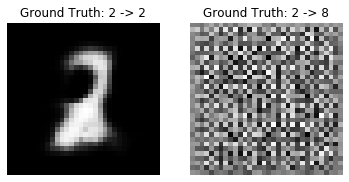

In [27]:
i = 12
recon_img_aen,_,_ = model_aen(torch.FloatTensor(example_data[i]).unsqueeze(0).to(device))
recon_img_gan,_,_ = model_gan(torch.FloatTensor(example_data[i]).unsqueeze(0).to(device))
plt.subplot(1,2,1)
plt.imshow(recon_img_aen[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
plt.title("Ground Truth: {} -> {}".format(example_targets[i], torch.argmax(model_classification(recon_img_aen)).item()))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(recon_img_gan[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
plt.title("Ground Truth: {} -> {}".format(example_targets[i], torch.argmax(model_classification(recon_img_gan)).item()))
plt.axis('off')